# Computational Aspects of Machine Learning - By Waleed Bin Khalid

This experiment is in conjunction with the paper submitted for the seminar **Computational Aspects of Machine Learning** at the Technical University of Munich. We compare the some numerical optimizers with respect to their accuracy and time complexity with the help of a simple example. We train a convolutional neural network to classify the well-known MNIST dataset which consists of 60,000 $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results.

Source: This experiment was taken from https://nextjournal.com/gkoehler/pytorch-mnist and edited to suit experimentation needs.

### We analyze the following Numerical Optimizers in this experiment with the aid of the well known MNIST dataset.
1. SGD
2. SGD with Momentum
3. Nesterov Momentum
4. Adagrad
5. ADAM
6. LBFGS
8. Hessian Free
9. Newton-CG

## Importing required libraries

In [1]:
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import timeit
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from network import Net

## Setting general hyperparameters

Throughout these experiments we work with the following hyperparameters. In somecases certain parameters are varied which are mentioned in the respective sections where the effect of the change of this parameter is discussed.

In [18]:
h_params = {'n_epochs' : 3,
'batch_size_train' : 32,
'batch_size_test' : 1000,
'learning_rate' : 0.01,
'momentum' : 0.9,
'log_interval' : 10,
'random_seed' : 1
}

# GPU is not available :(
torch.backends.cudnn.enabled = False
torch.manual_seed(h_params['random_seed'])

### Downloading the MNIST Dataset

We classify the well-known MNIST dataset which consists of 60,000, $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results. 

In [19]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_train'], shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_test'], shuffle=True)

## Outlook on the Dataset
The data is a set of 60,000 28x28 pixel images with corresponding ground truth labels.

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

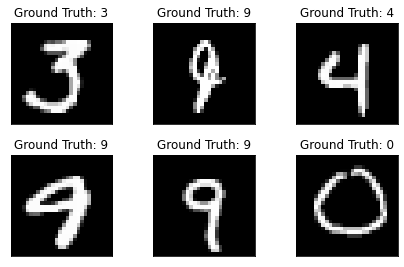

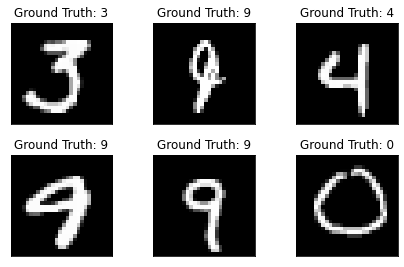

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### The Network
The `train` and `test` functions will be used to train the networks with different optimizers and will subsequently fill arrays that contain the data regarding the training and test loss. This will later be plotted for comparision. We will also store the time information.

Our network starts with two convolution layers of kernel size 5 each followed by two fully connected layers of size 50 and 10. The final fully connected layers has 10 outputs which map to the 10 classes available in the MNIST dataset. We also incorporate dropout and use ReLU as our activation function throughout the experiment.

We use the cross-entropy loss since we have a non-binary classification problem at our hands. 

In [30]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % h_params['log_interval'] == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*h_params['batch_size_train']) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

### Pre training
Before starting we show that the untrained network predicts each class with roughly the same weight. Hence we have an accuracy of ~ 10% as we have 10 classes and each class has an equal chance of getting selected by the untrained network. We can also see this visually as most of the labels are wrong.

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



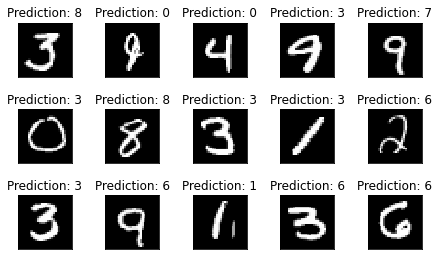

In [19]:
network = Net()

with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]


test()

## SGD
The first method we have is the stochastic gradient descent without momentum. We take independent identically distributed samples of data based on a batch size for each update. The batch size becomes another hyperparameter that we must care for during optimization.

$$\theta_{t+1}=\theta_{t}-\alpha \cdot \nabla_{\theta_t} J(\theta_{t+1}, x^{i:i+n}, y^{i:i+n})
$$

In [40]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=0)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd = toc - tic

train_losses_sgd = train_losses.copy()
train_counter_sgd = train_counter.copy()
test_losses_sgd = test_losses.copy()
test_counter_sgd = test_counter.copy()

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\Waleed Bin Khalid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3173, Accuracy: 1019/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.380477
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.258185
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.315163
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.275781
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307408
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.313525
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.355104
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.276285
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.284021
Train Epoch: 1 [2880/60000 (5%)]	Loss: 2.243930
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.227069
Train Epoch: 1 [3520/60000 (6%)]	Loss: 2.176183
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196723
Train Epoch: 1 [4160/60000 (7%)]	Loss: 2.221018
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.198963
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.028487
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.121501
Train Epoch: 1 [5440/60000 (9%)]	Loss: 2.083736
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.123920
Train Epoch: 1 [6080/60000 (10%)]	L

Train Epoch: 1 [52800/60000 (88%)]	Loss: 0.470473
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.686607
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.333677
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.837605
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.449066
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.518652
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.553585
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.729626
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.651406
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.390187
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.315309
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.341638
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.573534
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.492725
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.238855
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.316050
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.579879
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.194096
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.322347
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.811359


Train Epoch: 2 [45120/60000 (75%)]	Loss: 0.150098
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.344978
Train Epoch: 2 [45760/60000 (76%)]	Loss: 0.469035
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.486755
Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.218979
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.438749
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.117069
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.462631
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.234074
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.280029
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.251758
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.374869
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.409394
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.249694
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.263283
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.136974
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.403866
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.285544
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.230266
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.208514


Train Epoch: 3 [37440/60000 (62%)]	Loss: 0.139331
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.335095
Train Epoch: 3 [38080/60000 (63%)]	Loss: 0.397174
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.569705
Train Epoch: 3 [38720/60000 (65%)]	Loss: 0.519519
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.233937
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.247984
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.463674
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.190984
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.325980
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.245626
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.262587
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.313809
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.448416
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.640979
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.173150
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.394247
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.298855
Train Epoch: 3 [43200/60000 (72%)]	Loss: 0.561690
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.143425


### Visualization of SGD without Momentum

We visualize the training progress of the stochastic gradient method without the use of momentum and the resultant classification on some text images.

SGD Took 165.20727919999626 To Execute

Test set: Avg. loss: 0.0969, Accuracy: 9711/10000 (97%)



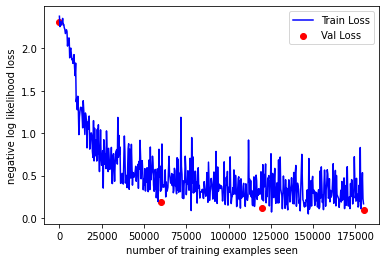

In [41]:
print("SGD Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd, train_losses_sgd, color='blue')
plt.scatter(test_counter_sgd, test_losses_sgd, color='red')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

# # fig

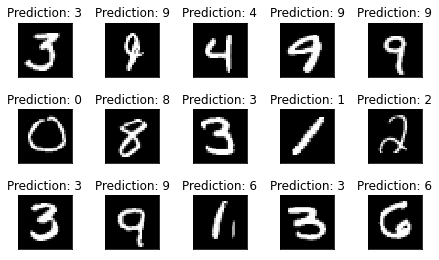

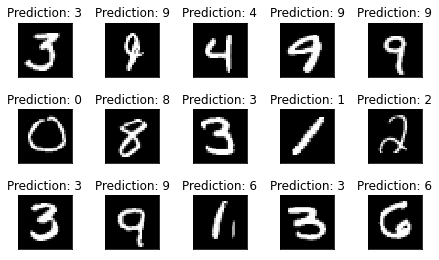

In [22]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## SGD With Momentum

SGD can be very erratic as we can have sharp steps in directions that do not produce any meaningful reduction in the loss in the learnable parameter space. By applying the concept of momentum, we want the previous updates of our trainable parameters to have an effect on the current learning step. The addition of momentum helps the SGD to step in relevant directions and dampens movement in directions that have too much variance. 
$$v_{t} = \beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta_{t}, x^{i:i+n}, y^{i:i+n})$$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [32]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_momentum = toc - tic

train_losses_sgd_momentum = train_losses.copy()
train_counter_sgd_momentum = train_counter.copy()
test_losses_sgd_momentum = test_losses.copy()
test_counter_sgd_momentum = test_counter.copy()


Test set: Avg. loss: 2.3146, Accuracy: 959/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376528
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.248521
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.219092
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.209551
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.872338
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.793456
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.513097
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.199779
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.406064
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.361202
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.327530
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.829529
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.915010
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.892676
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.783047
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.938932
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.898089
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.924268
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.656996
Train Epoch: 1 [6080/60000 (10%)]	Lo

Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.099747
Train Epoch: 1 [52800/60000 (88%)]	Loss: 0.371888
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.230469
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.279801
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.380904
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.245523
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.485530
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.185333
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.332297
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.267280
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.252588
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.074089
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.284434
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.319134
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.498997
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.204630
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.342979
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.148614
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.119589
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.242449


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.352017
Train Epoch: 2 [45120/60000 (75%)]	Loss: 0.460001
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.304911
Train Epoch: 2 [45760/60000 (76%)]	Loss: 0.101807
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.381134
Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.389540
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.106748
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.639446
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.063395
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.165093
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.623997
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.211021
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.217787
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.101149
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.161717
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.097682
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.274107
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.139792
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.122431
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.151252


Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.151632
Train Epoch: 3 [37440/60000 (62%)]	Loss: 0.155651
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.114246
Train Epoch: 3 [38080/60000 (63%)]	Loss: 0.099638
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.091419
Train Epoch: 3 [38720/60000 (65%)]	Loss: 0.134607
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.128821
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.235712
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.276464
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.562158
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.166910
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.134655
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.138550
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.144188
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.145613
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.053595
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.230597
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.486611
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.153267
Train Epoch: 3 [43200/60000 (72%)]	Loss: 0.104687


### Visualization of SGD with Momentum

We visualize the training progress of the stochastic gradient method with the use of momentum and the resultant classification on some text images.

SGD With Momentum Took 165.18269709999913 To Execute

Test set: Avg. loss: 0.0580, Accuracy: 9834/10000 (98%)



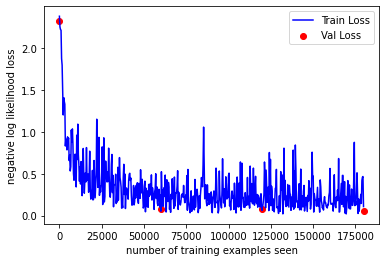

In [33]:
print("SGD With Momentum Took", time_sgd_momentum, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, color='blue')
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, color='red')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

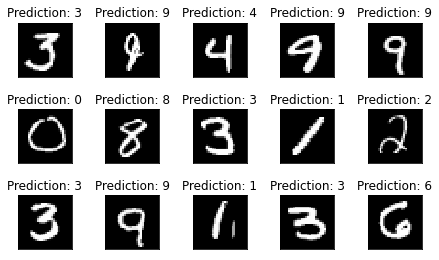

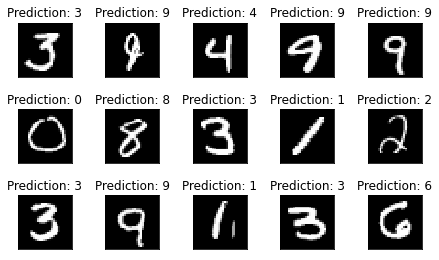

In [25]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Nesterov Momentum

We can also utilize the gradient of a future position for our update step instead of using the gradient at the current time step. For this reason, the Nestrov Momentum, or the look ahead momentum can be incorporated.

$$\theta^*_{t} = \theta_t + \beta v_{t-1} $$
$$v_{t} =\beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta^*_{t}, x^{i:i+n}, y^{i:i+n}) $$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [26]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'], nesterov=True)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_nestrov = toc - tic

train_losses_sgd_nestrov = train_losses.copy()
train_counter_sgd_nestrov = train_counter.copy()
test_losses_sgd_nestrov = test_losses.copy()
test_counter_sgd_nestrov = test_counter.copy()


Test set: Avg. loss: 2.3119, Accuracy: 745/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323633
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.281059
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.212948
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.104768
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.746699
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.534265
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.920177
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.170454
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.861764
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.873513
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.722510
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.916100
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.753711
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.888757
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.671680
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.701979
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.442160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.671520
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.697184
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.196957
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.308677
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.116582
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.476631
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.263017
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.627232
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.343836
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.413900
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.193950
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.415846
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.166029
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.207096
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.252870
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.263139
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.247666
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.402015
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.213706
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.156394
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.119454
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.100547


### Visualization for Neterov Momentum

We visualize the training progress of the Neterov Momentum method and the resultant classification on some text images.

Nestrov Took 120.1526159 To Execute

Test set: Avg. loss: 0.0581, Accuracy: 9814/10000 (98%)



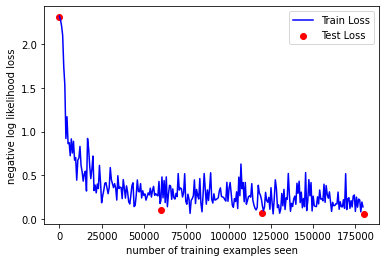

In [27]:
print("Nestrov Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, color='blue')
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

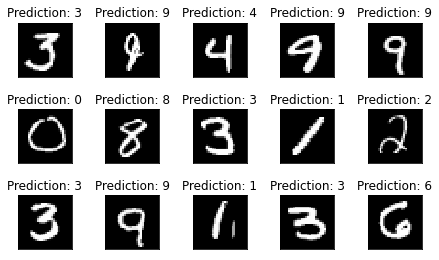

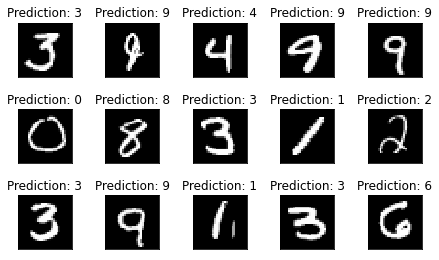

In [28]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparision of SGD, SGD Momentum and Nestrov


We can see that SGD without momentum gets stuck at a worse local minimum compared to the momentum methods. We also see a steeper fall for both the momentum methods which signifies that we have significantly improved the learning speed of our neural network.

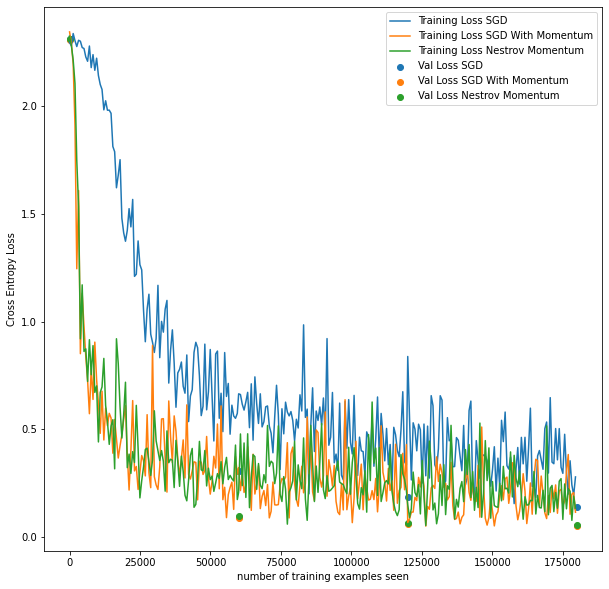

In [55]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_sgd, train_losses_sgd, label = "Training Loss SGD")
plt.scatter(test_counter_sgd, test_losses_sgd, label = "Val Loss SGD")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD With Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Val Loss SGD With Momentum")
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, label = "Training Loss Nestrov Momentum")
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, label = "Val Loss Nestrov Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
fig.savefig("figures/momentum_optimizer_comparision.pdf")
# # fig
# test_losses_sgd_nestrov

In [30]:
fig.savefig("momentum_optimizer_comparision.pdf", bbox_inches='tight')

### ADAGrad

ADAgrad uses the idea of weighing each learnable parameter with a different step size during the optimization step. The main advantage is that we do not need to tune the learning rate $\alpha$ and implementations use a default value of 0.01 as the accumulated gradient information adjusts the step-size for us. This is significant since hyper parameter tuning is a time consuming process and the learning rate is one of the most crucial hyper parameters that is often extremely difficult to tune properly. 

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t}$$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2}$$
$$\theta_{t+1}=m_{t}-\alpha \frac{\nu_{t}}{\sqrt{V_{t}}+\epsilon}$$

In [42]:
network = Net()
optimizer = optim.Adagrad(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adagrad = train_losses.copy()
test_losses_adagrad = test_losses.copy()
train_counter_adagrad = train_counter.copy()
test_counter_adagrad = test_counter.copy()


Test set: Avg. loss: 2.3114, Accuracy: 891/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288753
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.131988
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.117881
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.795108
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.264373
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.002703
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.120741
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.184741
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.318208
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.832939
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.921862
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.666126
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.668434
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.700022
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.683054
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.177855
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.536054
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.608013
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.530066
Train Epoch: 1 [6080/60000 (10%)]	Los

Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.396766
Train Epoch: 1 [52800/60000 (88%)]	Loss: 0.333512
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.591258
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.219885
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.372928
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.443843
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.147203
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.557459
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.199903
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.488479
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.276192
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.416739
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.301931
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.309752
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.479135
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.603245
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.769124
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.143416
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.234096
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.347468


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.516100
Train Epoch: 2 [45120/60000 (75%)]	Loss: 0.190706
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.392515
Train Epoch: 2 [45760/60000 (76%)]	Loss: 0.194896
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.290264
Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.256986
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.244219
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.604535
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.093144
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.423383
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.315570
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.204231
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.410421
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.362425
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.212050
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.689878
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.508690
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.265668
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.270736
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.223785


Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.424282
Train Epoch: 3 [37440/60000 (62%)]	Loss: 0.180769
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.273086
Train Epoch: 3 [38080/60000 (63%)]	Loss: 0.077369
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.240895
Train Epoch: 3 [38720/60000 (65%)]	Loss: 0.212767
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.277090
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.062443
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.207695
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.304906
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.271644
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.137074
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.114981
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.286587
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.669207
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.137496
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.287240
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.639083
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.215228
Train Epoch: 3 [43200/60000 (72%)]	Loss: 0.299182


### Visualizing results from ADAGrad

Text(0, 0.5, 'negative log likelihood loss')

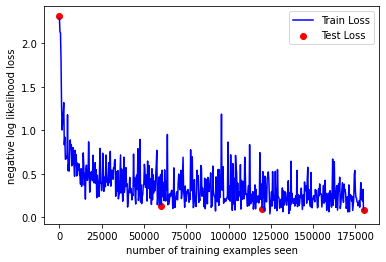

In [43]:
fig = plt.figure()
plt.plot(train_counter_adagrad, train_losses_adagrad, color='blue')
plt.scatter(test_counter_adagrad, test_losses_adagrad, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

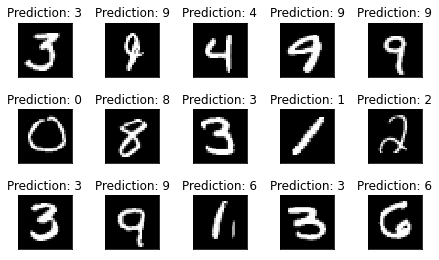

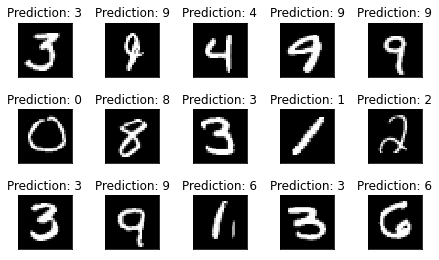

In [33]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## ADAM

The ADAM method uses the best of both worlds to combine the momentum methods and the adaptive learning rate methods to give what is now the staple numerical optimzer in most deep learning projects. The method stores both the exponentially decaying average of past gradients sqsuares i.e. the second momentum, along with the exponentially decaying average of past gradients i.e. first momentums.

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t} $$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2} $$
$$\hat{\nu_{t}}=\frac{\nu_{t}}{1-\beta_1}$$
$$\hat{V_{t}} = \frac{V_{t}}{1-\beta_2}$$
$$\theta_{t+1}=\theta_{t}-\alpha \frac{\hat{\nu_{t}}}{\sqrt{\hat{V_{t}}}+\epsilon}$$

In [44]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adam = train_losses.copy()
train_counter_adam = train_counter.copy()
test_losses_adam = test_losses.copy()
test_counter_adam = test_counter.copy()


Test set: Avg. loss: 2.3170, Accuracy: 1096/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338848
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.290453
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.274679
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.940225
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.205154
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.729573
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.540429
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.557789
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.557462
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.337009
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.593636
Train Epoch: 1 [3520/60000 (6%)]	Loss: 1.390067
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.263326
Train Epoch: 1 [4160/60000 (7%)]	Loss: 1.501355
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.177706
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.073491
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.223774
Train Epoch: 1 [5440/60000 (9%)]	Loss: 1.068804
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.242205
Train Epoch: 1 [6080/60000 (10%)]	L

Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.472699
Train Epoch: 1 [52800/60000 (88%)]	Loss: 0.511065
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.710449
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.515032
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.300527
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.739415
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.673778
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.534508
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.804493
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.950082
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.431212
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.796614
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.502851
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.668357
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.754160
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.487213
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.481234
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.494833
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.783031
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.835244


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.252832
Train Epoch: 2 [45120/60000 (75%)]	Loss: 0.549503
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.889394
Train Epoch: 2 [45760/60000 (76%)]	Loss: 0.316947
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.547942
Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.604145
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.413196
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.744458
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.540375
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.415982
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.536808
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.491115
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.110496
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.573519
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.587313
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.757291
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.817711
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.774736
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.648543
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.385367


Train Epoch: 3 [37440/60000 (62%)]	Loss: 0.819476
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.783768
Train Epoch: 3 [38080/60000 (63%)]	Loss: 0.456693
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.216625
Train Epoch: 3 [38720/60000 (65%)]	Loss: 0.510162
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.558428
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.458253
Train Epoch: 3 [39680/60000 (66%)]	Loss: 1.566966
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.948001
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.443943
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.590284
Train Epoch: 3 [40960/60000 (68%)]	Loss: 1.231215
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.885398
Train Epoch: 3 [41600/60000 (69%)]	Loss: 1.218608
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.511687
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.557155
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.709839
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.756094
Train Epoch: 3 [43200/60000 (72%)]	Loss: 1.213353
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.723383


### Visualizing the results form the ADAM Method

Text(0, 0.5, 'negative log likelihood loss')

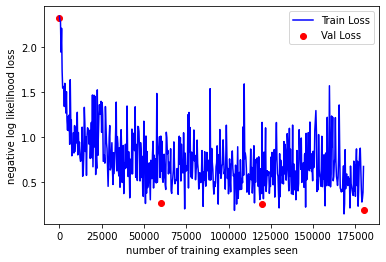

In [45]:
fig = plt.figure()
plt.plot(train_counter_adam, train_losses_adam, color='blue')
plt.scatter(test_counter_adam, test_losses_adam, color='red')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

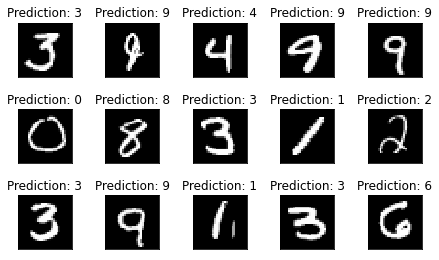

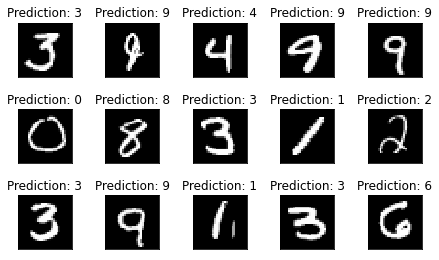

In [36]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## The non-convergence of Adaptive Methods

The ADAM method suffers from an important disadvantage as well in that, the method often does not converge. We can observe this by comparing it to SGD with momentum.

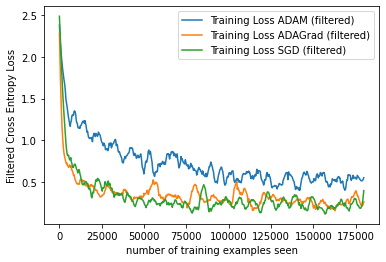

In [38]:
from scipy.signal import savgol_filter
fig, ax = plt.subplots()
box_pts=6
# box = np.ones(box_pts)/box_pts
adam_loss_moving_avg = savgol_filter(train_losses_adam, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_adam, adam_loss_moving_avg, label = 'Training Loss ADAM (filtered)')
adagrad_loss_moving_avg = savgol_filter(train_losses_adagrad, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_adagrad, adagrad_loss_moving_avg, label = 'Training Loss ADAGrad (filtered)')
sgdm_loss_moving_avg = savgol_filter(train_losses_sgd_momentum, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_sgd_momentum, sgdm_loss_moving_avg, label = 'Training Loss SGD (filtered)')
plt.legend()
plt.xlabel('number of training examples seen')
plt.ylabel('Filtered Cross Entropy Loss')
fig.savefig('figures/adam_vs_sgdm.pdf')

### ADAM vs ADAgrad vs SGD Momentum

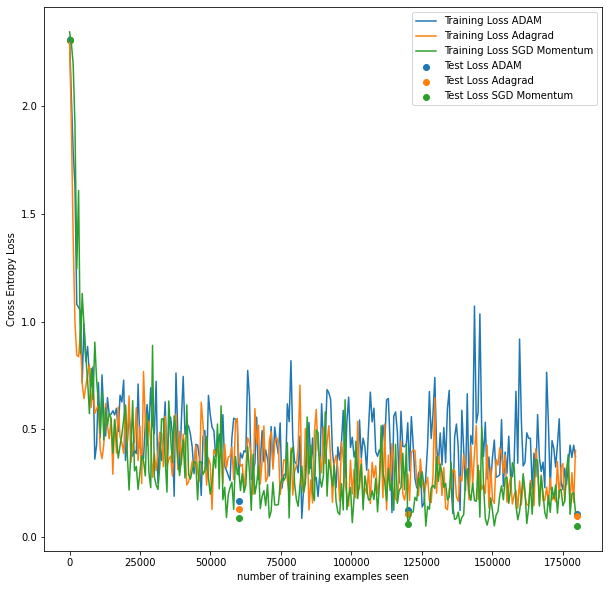

In [38]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_adam, train_losses_adam, label = "Training Loss ADAM")
plt.scatter(test_counter_adam, test_losses_adam, label = "Val Loss ADAM")
plt.plot(train_counter_adagrad, train_losses_adagrad, label = "Training Loss Adagrad")
plt.scatter(test_counter_adagrad, test_losses_adagrad, label = "Val Loss Adagrad")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Val Loss SGD Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
# # fig
# test_losses_sgd_nestrov

### LBFGS

We refer to the taylors expansion

$$J(\theta) \approx J(\theta_t)+\nabla J(\theta)^{\top} (\theta - \theta_t)+\frac{1}{2} (\theta - \theta_t)^{\top} \mathrm{H(\theta)} (\theta - \theta_t)$$

and approximate $H(\theta_t)$ with $H^{*}(\theta_t)$. The BFGS method stems from the Broyden's method where we iteratively build our matrix by minimizing the frobenius norm of $H^*_{t+1} - H^*_{t}$. We then make a minimal adjustment such that our matrix remains symmetric and positive definite. 

The BFGS method cannot be used to solve large scale problems due to the intense memory footprint that comes with generating a sequence of large matrices for high dimensional problems such as deep neural networks. The answer to this memory problem is the limited or L-BFGS method. The big difference is that we now only store a subset of the entire matrix by storing a few vectors out of the entire matrix. It is important to note that stochastic batches do not work well because it needs gradients of high quality in order to construct useful quadratic models and perform reliable line searches.

In [12]:
network = Net()
# lr need not be set
optimizer = optim.LBFGS(network.parameters(), lr=1)

train_losses = []
test_losses = []
train_counter_lbfgs = []
test_counter_lbfgs = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

def train_lbfgs():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        return loss
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_lbfgs.append(epoch)
        else:
            break

    
tic = timeit.default_timer()
train_lbfgs()
toc = timeit.default_timer()

time_lbfgs = toc-tic

train_losses_lbfgs = train_losses.copy()
test_losses_lbfgs = test_losses.copy()



Test set: Avg. loss: 2.3116, Accuracy: 168/10000 (2%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314597

Test set: Avg. loss: 0.5233, Accuracy: 8447/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.555156

Test set: Avg. loss: 0.2165, Accuracy: 9423/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.231839

Test set: Avg. loss: 0.1682, Accuracy: 9619/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.229113

Test set: Avg. loss: 0.1942, Accuracy: 9700/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.241569

Test set: Avg. loss: 0.4080, Accuracy: 9682/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.467515

Test set: Avg. loss: 0.2539, Accuracy: 9709/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.359897


### Visualizing results of the L-BFGS method

Text(0, 0.5, 'negative log likelihood loss')

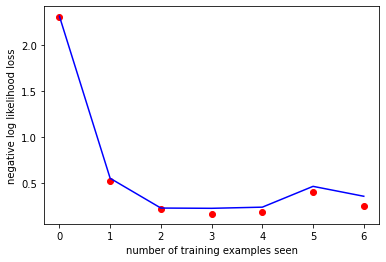

In [13]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, color='blue')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

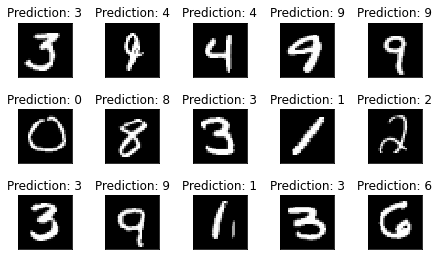

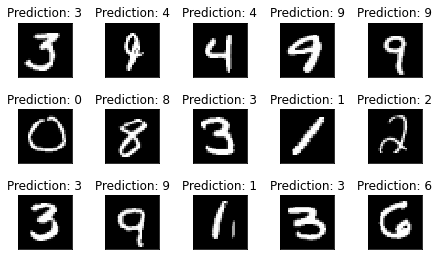

In [41]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Hessian Free

The Hessian Free method is very similar to the quasi Newton's method in that it uses local quadratic approximations for updates. However, unlike the previously discussed second order methods, if does not require any matrix inverse but rather uses the linear conjugate gradient method eliminating the need for the Hessian matrix.

Source: Optimization Code has been taken from https://github.com/moonl1ght/HessianFreeOptimization

In [14]:
from hf import HessianFree
network = Net()
# lr need not be set
optimizer = HessianFree(network.parameters())

train_losses = []
test_losses = []
train_counter_hf = []
test_counter_hf = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

def train_hf():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward(retain_graph=True)
        return loss, output
#     for epoch in range(5):
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_hf.append(epoch)
        else:
            break
                

tic = timeit.default_timer()
train_hf()
toc = timeit.default_timer()

time_hf = toc-tic
train_losses_hf = train_losses.copy()
test_losses_hf = test_losses.copy()


Test set: Avg. loss: 2.3094, Accuracy: 1009/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.215430

Test set: Avg. loss: 2.2159, Accuracy: 3010/10000 (30%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.567336

Test set: Avg. loss: 1.5747, Accuracy: 5629/10000 (56%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.895108

Test set: Avg. loss: 0.8835, Accuracy: 7154/10000 (72%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.858140

Test set: Avg. loss: 0.8614, Accuracy: 7113/10000 (71%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.848037

Test set: Avg. loss: 0.8515, Accuracy: 7725/10000 (77%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.735483

Test set: Avg. loss: 0.7461, Accuracy: 7578/10000 (76%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.535869


### Visualizing results of the Hessian Free method

Text(0, 0.5, 'negative log likelihood loss')

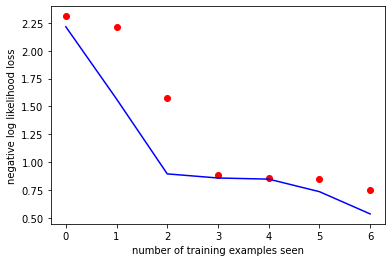

In [15]:
fig = plt.figure()
plt.plot(train_counter_hf, train_losses_hf, color='blue')
plt.scatter(test_counter_hf, test_losses_hf, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


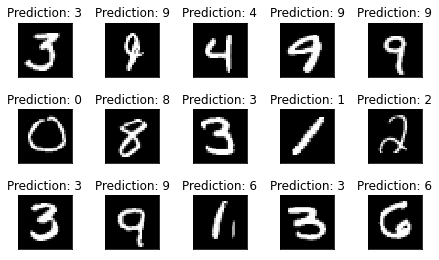

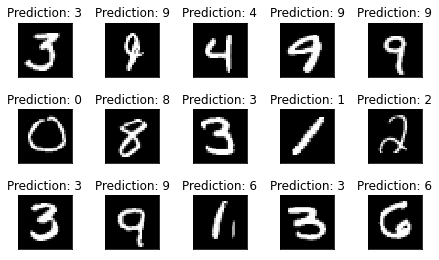

In [49]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparing L-BFGS with Hessian Free method

We observe that both methods require a very small number of very expensive iterations but the LBFGS method has a sharper fall which then settles at a more or less constant loss value.

Text(0, 0.5, 'Cross Entropy Loss')

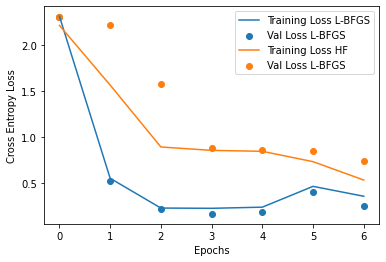

In [16]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, label = 'Training Loss L-BFGS')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, label = 'Val Loss L-BFGS')
plt.plot(train_counter_hf, train_losses_hf, label = 'Training Loss HF')
plt.scatter(test_counter_hf, test_losses_hf, label = 'Val Loss L-BFGS')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
# plt.savefig("figures/lbfgs_hf.pdf")

### Comparing time complexity of various first and second order methods

As expected we see that even though the second order methods have very few iteration counts, they require more time than the first order methods which have iteration counts that are orders of magnitude higher. This illustrates why the second order method despite their mathematical speed are not utilized too often in practical deep learning tasks.

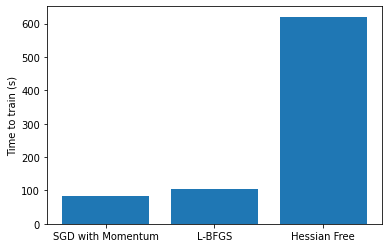

In [18]:
fig = plt.figure()
plt.bar(["SGD with Momentum", "L-BFGS", "Hessian Free"], [time_sgd_momentum, time_lbfgs, time_hf])
plt.ylabel("Time to train (s)")
fig.savefig("figures/execution_time.pdf")